# COGS 118A - Final Project

# Insert title here

# Names


- Eric Lin
- Cecilia Martinez
- Jared Singletary
- Finn St-John

# Abstract 
We will investigate the connection between features of a movie and its rating on the popular movie reviews website Rotten Tomatoes. This website classifies each movie as one of three categories: rotten, fresh, and certified fresh. We plan to use the non-cinematic features of movies to classify them into one of these three categories. Each data point will represent a movie and many of its characteristics. These features include things like genre, release date, runtime, etc. Almost all of these features are nominal or interval. We will be performing classification on our test data to predict the Rotten Tomatoes status of a movie. The status includes the aforementioned three categories. For model selection, we will perform grid-search cross validation and select the model with the best generalization. Since neither false positives nor false negatives pose more risk than the other in the context of our problem, we will evaluate the effectiveness of our model primarily using its f1 score, as this provides a metric that balances the impact of false negatives and false positives.


# Background

Movie ratings are an important aspect of the film industry, with many consumers relying on them to guide their viewing decisions. Rotten Tomatoes is a popular website that provides ratings based on the percentage of positive reviews for a given movie. These ratings are divided into three categories: rotten for scores below 60%, fresh for scores above 60%, and certified fresh for scores above 75% and at least 5 top critic reviews. Additionally, the website includes an audience score as a separate metric<sup id="cite_ref-1"><a href="#cite_note-1">[1]</a></sup>. Despite the popularity of such rating systems, recent research has raised questions about their accuracy in reflecting the opinions of the general public.

In a recent study<sup id="cite_ref-2"><a href="#cite_note-2">[2]</a></sup>, researchers found that movie rating scores on Rotten Tomatoes do not necessarily align with the sentiment of audience reviews. This highlights the need for a more nuanced approach to understanding audience preferences. Furthermore, movie popularity can vary significantly across genres, with certain genres like horror, comedy, mystery, and action performing poorly compared to others such as documentary, classics, and animation<sup id="cite_ref-3"><a href="#cite_note-3">[3]</a></sup>. These differences in popularity may impact the effectiveness of a machine learning algorithm trained on movie ratings data, suggesting the need for careful consideration of genre in the analysis.


# Problem Statement

The problem that our project is trying to solve is predicting the rotten tomatoes rating for a movie based on movie features including genre, release date, runtime, and content rating. We will do this by using machine learning algorithms like a random forest classifier and logistic regression to predict if a movie will receive a "fresh" rotten tomato score or a "rotten" score. 

The dataset we use makes this very much quantifiable, although certain variables are categorical and must therefore be either one-hot encoded or ordinally encoded so that we can work with it mathematically. We will divide our dataset up into 2/3 training data and 1/3 testing data and then use the metric of "Precision" to determine the success of our algorithm. 

# Data

Since we are trying to do an analysis of movies and how their features relate with their reviews, an ideal dataset for our project will allow us to compare several movie features with their review scores. 

Rotten Tomatoes Movies dataset
- https://www.kaggle.com/datasets/stefanoleone992/rotten-tomatoes-movies-and-critic-reviews-dataset?select=rotten_tomatoes_movies.csv
- This dataset has 17,712 observations and 22 variables per observation. 
- An observation in this dataset describes a single movie with many pieces of information about it.
- Some important variables are the rotten tomatoes score, the genre of the movie, and the director. 
- Since there is a good amount of categorical variables like genre and director, we will likely need to use one-hot encoding to clean up that data. 


In [100]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn

We read in our rotten tomatoes csv and select only the columns with the information we have deemed to be critical to our machine learning algorithm.

In [101]:
movies = pd.read_csv('data/rotten_tomatoes_movies.csv')
critical_columns = ['movie_title', 'content_rating', 'genres', 'directors', 'runtime', 'tomatometer_status', 
                    'tomatometer_rating', 'tomatometer_top_critics_count', 'tomatometer_fresh_critics_count',
                    'tomatometer_rotten_critics_count', 'original_release_date']
movies = movies[critical_columns]
movies.head()

,movie_title,content_rating,genres,directors,runtime,tomatometer_status,tomatometer_rating,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count,original_release_date
0,Percy Jackson & the Olympians: The Lightning T...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,119.0,Rotten,49.0,43,73,76,2010-02-12
1,Please Give,R,Comedy,Nicole Holofcener,90.0,Certified-Fresh,87.0,44,123,19,2010-04-30
2,10,R,"Comedy, Romance",Blake Edwards,122.0,Fresh,67.0,2,16,8,1979-10-05
3,12 Angry Men (Twelve Angry Men),NR,"Classics, Drama",Sidney Lumet,95.0,Certified-Fresh,100.0,6,54,0,1957-04-13
4,"20,000 Leagues Under The Sea",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,127.0,Fresh,89.0,5,24,3,1954-01-01


We know that the genre of the movie will be an important predictor, so we collect all the different genres into a set so we can see the unique values. 

In [102]:
genre_set = set()
for i in movies['genres']:
    if (type(i) == str):
        for j in i.split(','):
            j = j.strip()
            genre_set.add(j)
print(genre_set)

{'Sports & Fitness', 'Cult Movies', 'Kids & Family', 'Television', 'Horror', 'Gay & Lesbian', 'Action & Adventure', 'Art House & International', 'Animation', 'Classics', 'Documentary', 'Musical & Performing Arts', 'Science Fiction & Fantasy', 'Drama', 'Faith & Spirituality', 'Mystery & Suspense', 'Special Interest', 'Western', 'Romance', 'Comedy', 'Anime & Manga'}


We are interested in how many null values are in our csv because they can cause errors in our machine learning algorithms. We look through the columns and see how many null values they all have.

In [103]:
for i in movies.columns:
    print(i,movies[i].isnull().values.sum())

movie_title 0
content_rating 0
genres 19
directors 194
runtime 314
tomatometer_status 44
tomatometer_rating 44
tomatometer_top_critics_count 0
tomatometer_fresh_critics_count 0
tomatometer_rotten_critics_count 0
original_release_date 1166


Since there aren't very many null values across our columns, we will just drop all the null values to avoid any problems later on. 

In [104]:
movies = movies.dropna()
movies.shape

(16208, 11)

Genres list is a categorigal variable with no order. So we one hot encoded it.
To one hot encode the genres, first made genres into a new genres list. Then, applied Series to each 'genres list' element

In [105]:
movies['genres list'] = movies['genres'].str.split(', ', expand=False)
genres_series = movies['genres list'].apply(pd.Series).stack()
genres_encoded = pd.get_dummies(genres_series).groupby(level=0).sum()
# movies = pd.concat([movies, genres_encoded], axis=1)

genres_list = []
for i in genres_encoded.index:
    row_list = genres_encoded.loc[i, :].values.flatten().tolist()
    genres_list.append(row_list)

movies['genres_encoded'] = genres_list

Ratings have an order to it, so we turned it into an ordinal numerical value.

In [106]:
ratings = {'G': 0, 'PG': 1, 'PG-13': 2, 'R': 3, 'NR': 4, 'NC17': 5}

movies['content_rating_id'] = movies['content_rating'].map(ratings)

We turned original release date into a pandas date time object so we can easily compare it to each other

In [107]:
movies['original_release_date'] = pd.to_datetime(movies['original_release_date'])

In [108]:
#reordering the columns
reordered_columns = ['movie_title', 'content_rating', 'content_rating_id', 'genres', 'genres_encoded', 'directors',
                    'runtime', 'original_release_date', 'tomatometer_status', 'tomatometer_rating', 
                    'tomatometer_top_critics_count', 'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count']
movies = movies[reordered_columns]
movies.head()

,movie_title,content_rating,content_rating_id,genres,genres_encoded,directors,runtime,original_release_date,tomatometer_status,tomatometer_rating,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
0,Percy Jackson & the Olympians: The Lightning T...,PG,1,"Action & Adventure, Comedy, Drama, Science Fic...","[1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",Chris Columbus,119.0,2010-02-12,Rotten,49.0,43,73,76
1,Please Give,R,3,Comedy,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Nicole Holofcener,90.0,2010-04-30,Certified-Fresh,87.0,44,123,19
2,10,R,3,"Comedy, Romance","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Blake Edwards,122.0,1979-10-05,Fresh,67.0,2,16,8
3,12 Angry Men (Twelve Angry Men),NR,4,"Classics, Drama","[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",Sidney Lumet,95.0,1957-04-13,Certified-Fresh,100.0,6,54,0
4,"20,000 Leagues Under The Sea",G,0,"Action & Adventure, Drama, Kids & Family","[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...",Richard Fleischer,127.0,1954-01-01,Fresh,89.0,5,24,3


# Proposed Solution

We predict that these features, while not completely evident in the content of the movie, will be a large predictor of the movie’s rating. More specifically, we predict that the director will have a large influence on the overall rating given to the movie. Additionally, we predict that certain genres will be rated more highly than others across the board. We believe that a classification model will be able to effectively find a connection between director and rating and genre and rating. We will test each solution using our selected metric: the f1 score of a model. We believe that there is a connection to discover between these non-cinematic characteristics and the rating of the movie, whether it is a large connection or small connection, and therefore believe that a classification model will be able to effectively identify this connection.

The classifiers we have tested are support vector machines, logistic regression, and random forest. There are a two things to consider when selecting our model. We must consider the ability of the model to approximate more complex functions, and we must consider the interpretability of the classifier. SVMs, while powerful are not very interpretable. Logistic Regression is less powerful, but more interpretable. 

After performing grid search cross-validation on these three algorithms, we are most interested in using a random forest classifier.

Because we are looking to discover an inherent connection between certain features of our data, we would like to select the most interpretable model. However, because model interpretability scales inversely with model capacity (the amount of functions a model can approximate), we have to balance these two characteristics. Because we need to find a good medium, we are looking into using a random forest classifier. Random forest classifiers comprise many decision trees. Decision trees are some of the most interpretable classifiers available for use. Additionally, because random forests are ensemble learners, it's acceptable to use a less complex model (decision trees, in this case). 

Using a random forest classifier allows us to get the best of both worlds. Our model will have high interpretability, as well as a high model capacity and high prediction ability.

# Evaluation Metrics

The evaluation model we will use will be based on precision, as it is the most valuable metric to look at in the context of this problem. 

If a filmmaker were to create a movie based on this machine learning algorithm, spending money, time, and effort on a movie that our model predicted would do well, but then flops in reality (false positive), there would be significantly worse consequences for the filmmaker than a movie that’s expected to do poorly but ends up doing really well (false negative). A false negative would have little effect when actually using our model in practice, as filmmakers rarely have the intention of making a bad movie. As such, maximizing the precision score would minimize the amount of false positives, making a more useful model. 

Precision = True Positive/(True Positive + False Positive)


# Results

### Some more data formatting

In [109]:
status_encoded = pd.get_dummies(movies['tomatometer_status']).groupby(level=0).sum()

status_list = []
for i in status_encoded.index:
    row_list = status_encoded.loc[i, :].values.flatten().tolist()
    status_list.append(row_list[::-1])

movies['status_encoded'] = status_list

# turn tomatometer status into binary so that we can use binary classifiers
binary_encoding = []
certified_fresh = [0, 0, 1]
fresh = [0, 1, 0]
# for each one hot encoded list
for val in status_list:
    # val is fresh or certified fresh
    if val in [fresh, certified_fresh]:
        binary_encoding.append(1)
    else:
        binary_encoding.append(0)
        
movies['binary_tomatometer_status'] = binary_encoding

movies.head()

,movie_title,content_rating,content_rating_id,genres,genres_encoded,directors,runtime,original_release_date,tomatometer_status,tomatometer_rating,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count,status_encoded,binary_tomatometer_status
0,Percy Jackson & the Olympians: The Lightning T...,PG,1,"Action & Adventure, Comedy, Drama, Science Fic...","[1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",Chris Columbus,119.0,2010-02-12,Rotten,49.0,43,73,76,"[1, 0, 0]",0
1,Please Give,R,3,Comedy,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Nicole Holofcener,90.0,2010-04-30,Certified-Fresh,87.0,44,123,19,"[0, 0, 1]",1
2,10,R,3,"Comedy, Romance","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Blake Edwards,122.0,1979-10-05,Fresh,67.0,2,16,8,"[0, 1, 0]",1
3,12 Angry Men (Twelve Angry Men),NR,4,"Classics, Drama","[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",Sidney Lumet,95.0,1957-04-13,Certified-Fresh,100.0,6,54,0,"[0, 0, 1]",1
4,"20,000 Leagues Under The Sea",G,0,"Action & Adventure, Drama, Kids & Family","[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...",Richard Fleischer,127.0,1954-01-01,Fresh,89.0,5,24,3,"[0, 1, 0]",1


In [110]:
# create month column
movies['original_release_date']

movies['original_release_month'] = [d.month for d in movies['original_release_date']]

After some formatting, test estimators on predicting `tomatometer_status` using rating, runtime, release month, and genres.

Our selected classifiers include:
1. SVM
2. Logistic Regression
3. Random Forests

Each of these can be used as binary classifiers, so they should apply well to our data & problem. This set of algorithms also tests high and low interpretability and high and low complexity/power. 

In [140]:
selected_columns = ['original_release_month', 'genres_encoded', 'runtime', 'content_rating_id']

data = np.array(movies[selected_columns])

vectorized_data = []
for d in data:
    data_point = []
    for feature in d:
        if type(feature) is list:
            data_point.extend(feature)
        else:
            data_point.append(feature)
    vectorized_data.append(data_point)

### Testing some classifiers

Classifiers and hyperparameters we tested:

#### SVM:
- C: 0.1, 1, 5, 10, 100
- Kernel: linear, RBF

#### Logistic Regression:
- Penalty: L1, L2
- C: 0.01, 0.1, 1, 10
- Solver: Liblinear, Saga

#### Random Forest:
- Number of Estimators: 100, 200, 400, 600
- Criterion: Gini, Entropy
- Max Depth: 50, 60, 90
- Minimum Samples for Split: 2, 7, 9, 12
- Max Features: Square-root

In [191]:
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from scipy.stats import uniform, truncnorm, randint

import json

In [192]:
X = np.array(vectorized_data)
y = np.array(movies['binary_tomatometer_status'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [193]:
def select_best(*models):
    best = models[0]
    for model in models:
        # should select best model based on lowest accuracy
        if model['score'] < best['score']:
            best = model
    return best

def save_best_model(grid_search, filepath):
    new_model = {
        'parameters': grid_search.best_params_,
        'score': grid_search.best_score_
    }
    current_best = read_results(filepath)
    if current_best != {}:
        write_results(filepath, select_best(new_model, current_best))
    else:
        write_results(filepath, new_model)
    
def read_results(filepath):
    with open(filepath) as f:
        content = f.read()
        if content == '':
            return {}
        else:
            return json.loads(content)
        
def write_results(filepath, model):
    with open(filepath, 'w') as f:
        f.write(json.dumps(model))
        
def plot_results(grid_search):
    params = grid_search.cv_results_["params"]
    ys = grid_search.cv_results_["mean_test_score"]
    xs = ['|'.join(str(v) for v in param.values()) for param in params]
    yerr = grid_search.cv_results_["std_test_score"]
    plt.errorbar(xs, ys, yerr / np.sqrt(grid_search.cv), fmt='.k')
    plt.ylabel("f1")
    plt.xlabel("params")

In [196]:
svm_pipe_gs = Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC(random_state=42))])

svm_param_grid_gs = {
    'svc__C': [1, 5, 10, 100],
    'svc__kernel': ['linear', 'rbf']
}

svm_gscv = GridSearchCV(svm_pipe_gs, svm_param_grid_gs, cv=5, verbose=1)

In [93]:
svm_gscv.fit(X_train, y_train)

save_best_model(svm_gscv, './model_selection_results/SVM.json')

Fitting 2 folds for each of 8 candidates, totalling 16 fits


In [195]:
plot_results(svm_gscv)

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [197]:
logistic_pipe_gs = Pipeline(steps=[('scaler', StandardScaler()), ('logistic', LogisticRegression(random_state=42))])

logistic_param_grid_gs = {
    'logistic__penalty': ['l1', 'l2'],
    'logistic__C': [0.01, 0.1, 1, 10],
    'logistic__solver': ['liblinear', 'saga']
}

logistic_gscv = GridSearchCV(logistic_pipe_gs, logistic_param_grid_gs, cv=5, verbose=1)

In [175]:
logistic_gscv.fit(X_train, y_train)

save_best_model(logistic_gscv, './model_selection_results/LogisticRegression.json')

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV] END logistic__C=0.01, logistic__penalty=l1, logistic__solver=liblinear; total time=   0.0s
[CV] END logistic__C=0.01, logistic__penalty=l1, logistic__solver=liblinear; total time=   0.0s
[CV] END logistic__C=0.01, logistic__penalty=l1, logistic__solver=saga; total time=   0.0s
[CV] END logistic__C=0.01, logistic__penalty=l1, logistic__solver=saga; total time=   0.0s
[CV] END logistic__C=0.01, logistic__penalty=l2, logistic__solver=liblinear; total time=   0.0s
[CV] END logistic__C=0.01, logistic__penalty=l2, logistic__solver=liblinear; total time=   0.0s
[CV] END logistic__C=0.01, logistic__penalty=l2, logistic__solver=saga; total time=   0.0s
[CV] END logistic__C=0.01, logistic__penalty=l2, logistic__solver=saga; total time=   0.0s
[CV] END logistic__C=0.1, logistic__penalty=l1, logistic__solver=liblinear; total time=   0.0s
[CV] END logistic__C=0.1, logistic__penalty=l1, logistic__solver=liblinear; total time=   0.0s
[

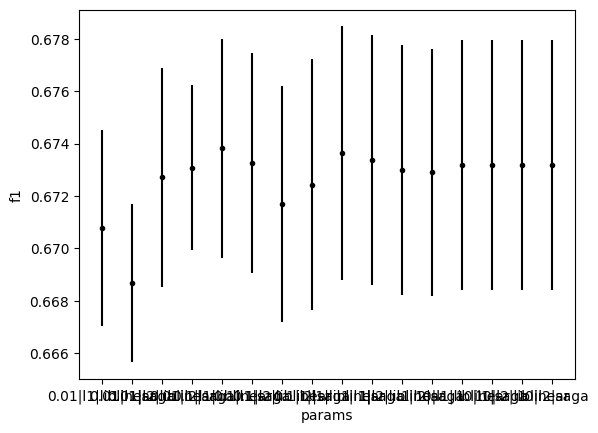

In [176]:
plot_results(logistic_gscv)

In [198]:
forest_pipe_gs = Pipeline(steps=[('scaler', StandardScaler()), ('forest', RandomForestClassifier(random_state=42))])

forest_param_grid_gs = {
    'forest__n_estimators': [100, 200, 400],
    'forest__criterion': ['gini', 'entropy'],
    'forest__max_depth': [50, 60, 90],
    'forest__min_samples_split': [2, 7, 9, 12],
    'forest__max_features': ['sqrt'],
    'forest__bootstrap': [True]
}

forest_gscv = GridSearchCV(forest_pipe_gs, forest_param_grid_gs, cv=5, verbose=1)

In [ ]:
forest_gscv.fit(X_train, y_train)

save_best_model(forest_gscv, './model_selection_results/RandomForest.json')

In [187]:
plot_results(forest_gscv)

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

### Randomized Search Cross Validation

In [199]:
logistic_pipe_rs = Pipeline(steps=[('scaler', StandardScaler()), ('logistic', LogisticRegression(random_state=42))])

logistic_param_grid_rs = {
    'logistic__penalty': ['l1', 'l2'],
    'logistic__C': uniform(0.1, 100),
    'logistic__solver': ['liblinear', 'saga']
}

logistic_rscv = RandomizedSearchCV(logistic_pipe_rs, logistic_param_grid_rs, cv=5, verbose=1)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


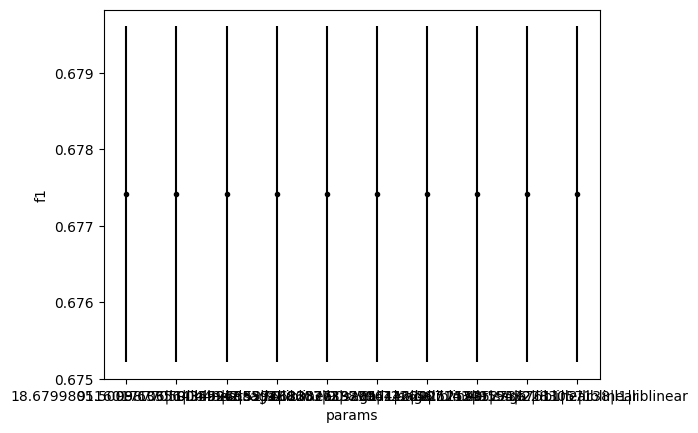

In [204]:
logistic_rscv.fit(X_train, y_train)

save_best_model(logistic_rscv, './model_selection_results/LogisticRegression.json')

plot_results(logistic_rscv)

In [200]:
svm_pipe_rs = Pipeline(steps=[('scaler', StandardScaler()), ('logistic', LogisticRegression(random_state=42))])

svm_param_grid_rs = {
    'svc__C': randint(1,100),
    'svc__kernel': ['linear', 'rbf']
}

svm_rscv = RandomizedSearchCV(svm_pipe_rs, svm_param_grid_rs, cv=5, verbose=1)

In [ ]:
svm_rscv.fit(X_train, y_train)svm

save_best_model(svm_rscv, './model_selection_results/SVM.json')

plot_results(svm_rscv)

In [201]:
forest_pipe_rs = Pipeline(steps=[('scaler', StandardScaler()), ('forest', RandomForestClassifier(random_state=42))])

forest_param_grid_rs = {
    'forest__n_estimators': [100, 200, 400],
    'forest__criterion': ['gini', 'entropy'],
    'forest__max_depth': [50, 60, 90],
    'forest__min_samples_split': [2, 7, 9, 12],
    'forest__max_features': ['sqrt'],
    'forest__bootstrap': [True]
}

forest_rscv = GridSearchCV(forest_pipe_rs, forest_param_grid_rs, cv=5, verbose=1)

In [ ]:
forest_rscv.fit(X_train, y_train)

save_best_model(forest_rscv, './model_selection_results/RandomForest.json')

plot_results(forest_rscv)

### Testing other validation methods

- Let's try other validation algorithms:
  - K-fold cross validation
  - RandomizedSearchCV

# Ethics & Privacy

Since the dataset that we are working with is only using publicly available information about Hollywood movies from the Rotten Tomatoes website, our Machine Learning analysis should not end up running into ethical concerns. One consideration we are taking into account is that this dataset has the names of all the movie reviewers in it, which could be an ethical concern if we include their names in our analysis. We’re going to avoid that though by completely ignoring the names of the critics and dropping it from the data since their names are irrelevant to our project. 

# Discussion

### Interpreting the result

OK, you've given us quite a bit of tech information above, now its time to tell us what to pay attention to in all that.  Think clearly about your results, decide on one main point and 2-4 secondary points you want us to understand. Highlight HOW your results support those points.  You probably want 2-5 sentences per point.

### Limitations

Are there any problems with the work?  For instance would more data change the nature of the problem? Would it be good to explore more hyperparams than you had time for?   

### Ethics & Privacy

Since the dataset that we are working with is only using publicly available information about Hollywood movies from the Rotten Tomatoes website, our Machine Learning analysis should not end up running into ethical concerns. One consideration we are taking into account is that this dataset has the names of all the movie reviewers in it, which could be an ethical concern if we include their names in our analysis. We’re going to avoid that though by completely ignoring the names of the critics and dropping it from the data since their names are irrelevant to our project. 

### Conclusion

Reiterate your main point and in just a few sentences tell us how your results support it. Mention how this work would fit in the background/context of other work in this field if you can. Suggest directions for future work if you want to.

# Footnotes

<div class="footnotes">
<hr>
<ol>
  <li id="cite_note-1">
    <span>Liao, E. (2018, December 8). Can We Predict Rotten Tomatoes Ratings? Towards Data Science. <a href="https://towardsdatascience.com/can-we-predict-rotten-tomatoes-ratings-8b5f5b7d7eff">(source)</a></span>
    <a href="#cite_ref-1" title="Jump back to footnote 1 in the text.">↩</a>
  </li>
  <li id="cite_note-2">
    <span>Maio, A. (2020, March 4). How Does Rotten Tomatoes Actually Work? Studio Binder. <a href="https://www.studiobinder.com/blog/rotten-tomatoes-ratings-system/">(source)</a></span>
    <a href="#cite_ref-2" title="Jump back to footnote 2 in the text.">↩</a>
  </li>
  <li id="cite_note-3">
    <span>Roper, H. (2021, January 20). What makes for a good movie? Towards Data Science. <a href="https://towardsdatascience.com/what-makes-for-a-good-movie-8e10896e0f1b">(source)</a></span>
    <a href="#cite_ref-3" title="Jump back to footnote 3 in the text.">↩</a>
  </li>
</ol>
</div>
